Here we are importing all the necessary models -- note that we are using Keras for the models, SKLearn for a lot of the preprocessing and model selection, and glob, pandas, and matplotlib to handle a lot of the background work (with the others being used pretty sparingly).

In [6]:
import keras
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import warnings
from skimage import exposure

import pickle
%matplotlib inline 
matplotlib.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

hello world


The below is splitting the data into the correct sections (test,train), and the following section is showing a random sample of traffic signs from the German traffic signs dataset!

In [14]:
#loading the test and train data
training_file = "data/train.p"
testing_file = "data/test.p"

#opening the file and saving the data inside the train/test variables
with open(training_file, mode="rb") as f: train = pickle.load(f)
with open(testing_file, mode="rb") as f: test = pickle.load(f)

#divide train and test data
X,y = train['features'], train['labels']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=4000, random_state=0)
x_test, y_test = test['features'], test['labels']

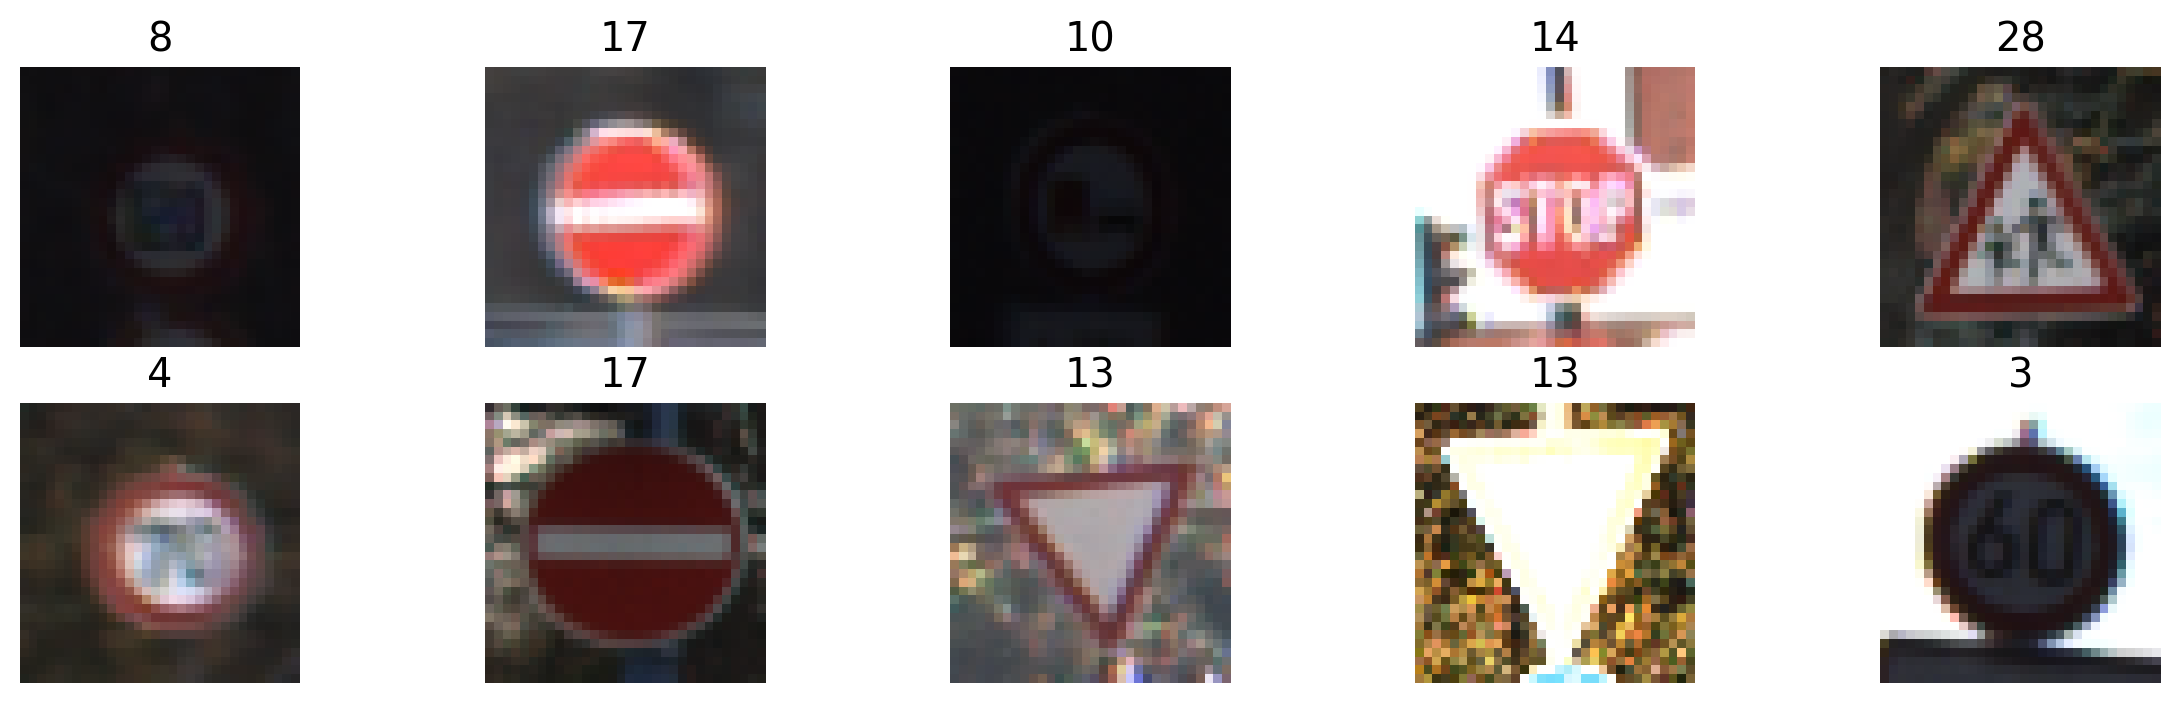

In [15]:
#showing some of the random photos 
figure, axis = plt.subplots(2,5,figsize=(15,4))
figure.subplots_adjust(hspace=.2, wspace=.001)
axis = axis.ravel()
for i in range(10):
    index = random.randint(0, len(x_train))
    image = x_train[index]
    axis[i].axis('off')
    axis[i].imshow(image)
    axis[i].set_title(y_train[index])

All the data is classified by a "number" which indicates that it specifically is (the sign). Below we are plotting a histogram of the a moutn of numbers prevalent in the dataset to show that it's not really even adn that there are some biases in the frequency distribution - this means that it's possible certain images/signs are better predicted simply because there exists more data for them.

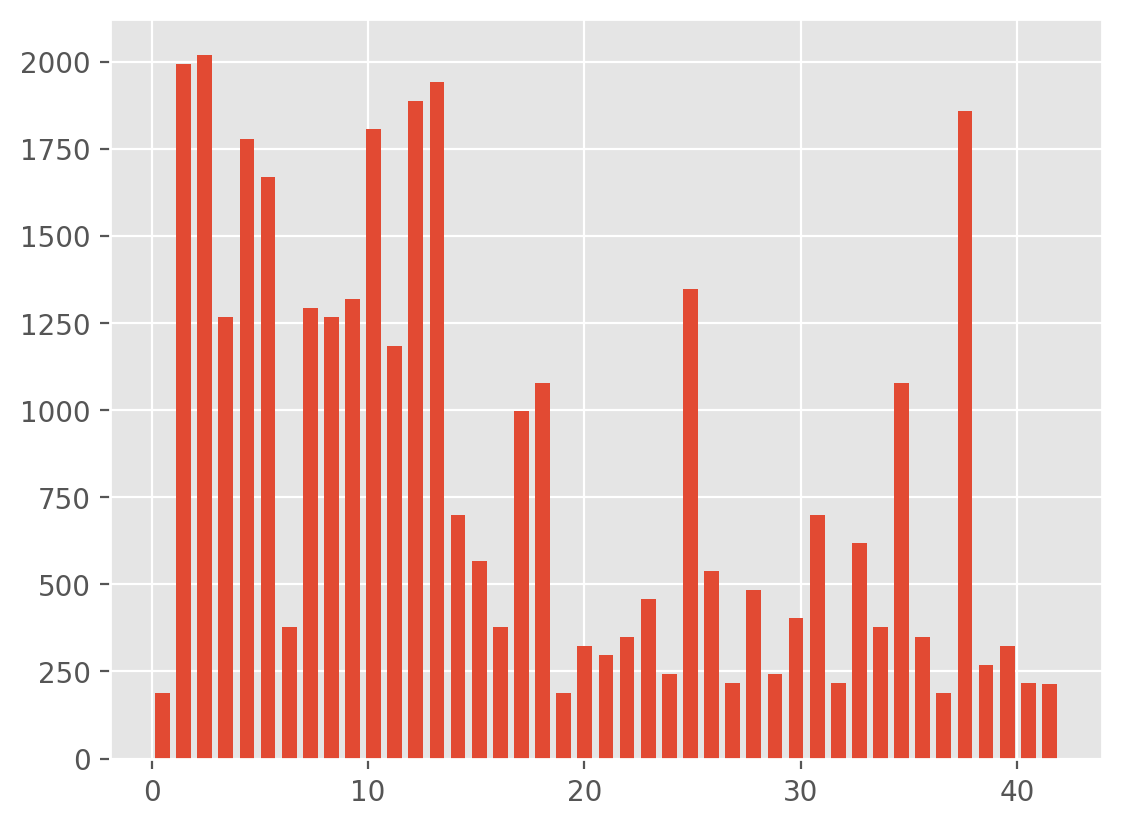

In [18]:
image_rows, image_cols = 32, 32
batch_size = 256
num_classes = 43
epochs = 10
histogram, the_bins = np.histogram(y_train, bins=num_classes) 
the_width = .7 * (the_bins[1] - the_bins[0])
center = (the_bins[:-1] + the_bins[1:]) / 2
plt.bar(center, histogram, align="center", width = the_width) 
plt.show()

We are trying to do the same thing we did above across the train/test split and plot it as another frequency plot.

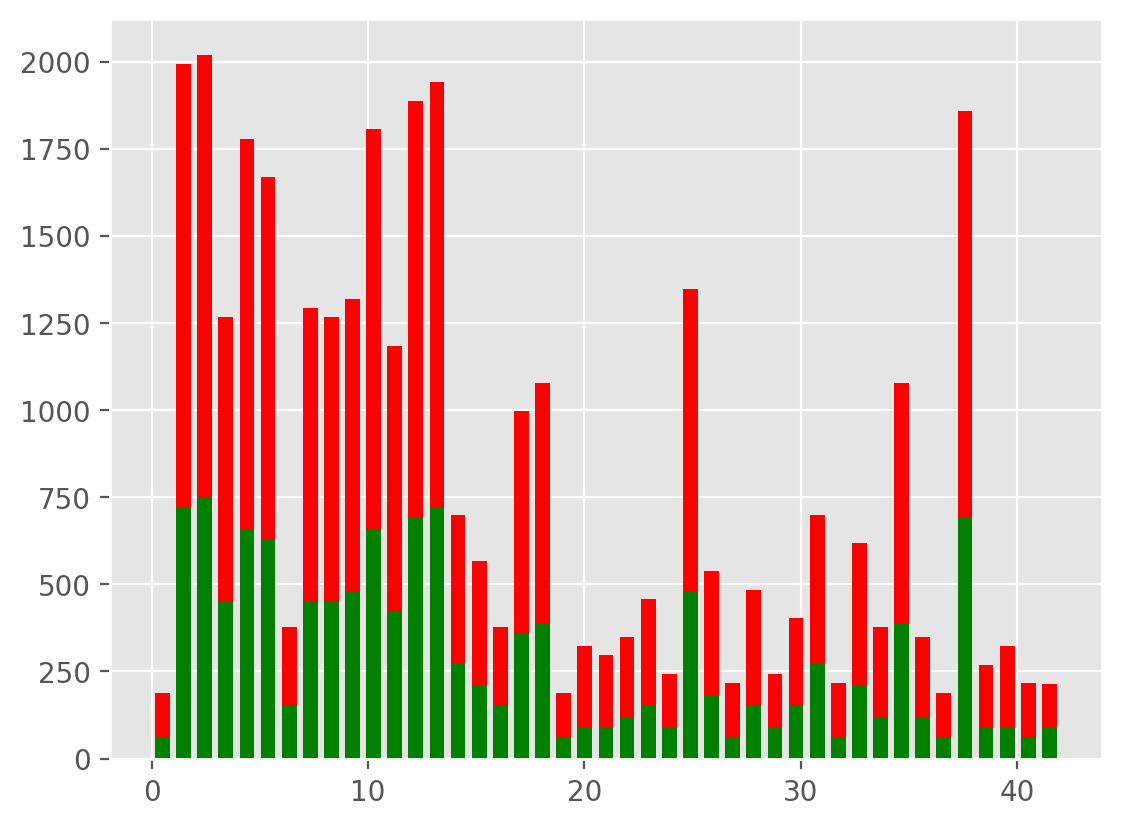

In [21]:
#trying to divvy the data into test and train to see what the classes are across the train/test split
train_hist, train_bins = np.histogram(y_train, bins=num_classes)
test_hist, test_bins = np.histogram(y_test, bins = num_classes)
train_width = .7*(train_bins[1] - train_bins[0]) 
train_center = (train_bins[:-1] + train_bins[1:]) /2
test_width = .7* (test_bins[1] - test_bins[0])
test_center = (test_bins[:-1] + test_bins[1:]) /2

#this is plotting a similar frequency
plt.bar(train_center, train_hist, align="center", color="red", width=train_width)
plt.bar(test_center, test_hist, align="center", color="green", width=test_width)
plt.show() 

In [22]:
#printing information regarding the training and testing data\
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (35209, 32, 32, 3)
35209 train samples
12630 test samples


In [24]:
y_train = keras.utils.to_categorical(y_train, num_classes) 
y_test = keras.utils.to_categorical(y_test, num_classes)

if K.image_data_format() == 'channels_first':
    input_shape = (1, image_rows, image_cols)
else:
    input_shape = (image_rows, image_cols, 1)

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape = (32, 32, 3)))

model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(50, (5,5), padding="same")) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten()) 
model.add(Dense(5000))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 50)        20050     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0

2024-07-11 11:10:04.952994: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-11 11:10:04.953922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 11:10:04.956443: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
#now we can try to compile the model to train it
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
theLeNetModel = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, verbose = 1, validation_data = (x_test, y_test))


2024-07-11 11:11:45.861425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-11 11:11:45.862812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3417595000 Hz


Epoch 1/10
138/138 [==============================] - 32s 231ms/step - loss: 3.7598 - accuracy: 0.0144 - val_loss: 3.7456 - val_accuracy: 0.0524
Epoch 2/10
138/138 [==============================] - 31s 224ms/step - loss: 3.7412 - accuracy: 0.0623 - val_loss: 3.7261 - val_accuracy: 0.1002
Epoch 3/10
138/138 [==============================] - 29s 211ms/step - loss: 3.7211 - accuracy: 0.0947 - val_loss: 3.7040 - val_accuracy: 0.1210
Epoch 4/10
138/138 [==============================] - 31s 222ms/step - loss: 3.6977 - accuracy: 0.1030 - val_loss: 3.6778 - val_accuracy: 0.1022
Epoch 5/10
138/138 [==============================] - 30s 220ms/step - loss: 3.6710 - accuracy: 0.0885 - val_loss: 3.6469 - val_accuracy: 0.0756
Epoch 6/10
138/138 [==============================] - 29s 212ms/step - loss: 3.6417 - accuracy: 0.0755 - val_loss: 3.6126 - val_accuracy: 0.0699
Epoch 7/10
138/138 [==============================] - 29s 214ms/step - loss: 3.6030 - accuracy: 0.0739 - val_loss: 3.5785 - val_ac